In [1]:
import pandas as pd
import numpy as np

# 한글 폰트 깨짐 방지
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#에러 무시
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale, minmax_scale, robust_scale

import xgboost as xgb

import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# 속도와 각도 선형관계 있는 공식 찾기
# 찾은 후, 그 수치가 일정 수준 넘어가면 배럴이라는 것을 정의해야 함

In [3]:
hts = pd.read_csv('hts.csv', encoding = 'CP949')

## 전처리
- 번트는 타격이 아니고 가져다 대는 것이므로 삭제
- 안타여부와 장타여부 표시
 - 안타는 1
 - 장타는 1루타 : 1 / 2루타 : 2 / 3루타 : 3 / 홈런 : 4

In [4]:
# 번트는 팀 직전 타구이기 때문에 삭제

hts = hts.loc[(hts['타격결과'] != '번트안타')&
       (hts['타격결과'] != '번트아웃')&
       (hts['타격결과'] != '희생번트')]
hts.reset_index(drop = True, inplace = True)

# 안타 여부 표시
hts['안타여부'] = 0
hts['장타여부'] = 0

# 안타가 된 타구만 1로 
hts['안타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '2루타')] = 1
hts['안타여부'][(hts['타격결과'] == '3루타')] = 1
hts['안타여부'][(hts['타격결과'] == '홈런')] = 1
hts['안타여부'][(hts['타격결과'] == '직선타')] = 1 # 직선타를 안타로 설정

# 장타가 된 타구
hts['장타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '내야안타(1루타)')] = 1
hts['장타여부'][(hts['타격결과'] == '2루타')] = 2
hts['장타여부'][(hts['타격결과'] == '3루타')] = 3
hts['장타여부'][(hts['타격결과'] == '홈런')] = 4

In [5]:
hts = hts[['경기코드', '선수코드', '이닝', '타구속도', '발사각도', '타격결과', '안타여부', '장타여부']]

In [6]:
# # 이상치 제거
# # 함수 정의
# def outlier(df, column):   
    
#     Q1 = np.quantile(df[column], 0.25)
#     Q3 = np.quantile(df[column], 0.75)   
#     IQR = Q3 - Q1               
#     minimum = Q1 - (IQR * 1.5)
#     maximum = Q3 + (IQR * 1.5)
#     print('---------', column, '의 이상치---------')
#     print('IQR :',IQR)     
#     print('minimum :', minimum)     
#     print('maximum :', maximum)
    
#     NumOfOutlier = df[(df[column] > maximum) | (df[column] < minimum)].shape[0]
#     print('upper bound 이상치 개수 : ', df[df[column] > maximum].shape[0])
#     print('lower bound 이상치 개수 : ', df[df[column] < minimum].shape[0])
#     print('총 이상치 개수 : ', NumOfOutlier)

In [7]:
# outlier(hts, '타구속도')

In [8]:
# outlier(hts, '발사각도')

In [9]:
# hts = hts[(hts['타구속도'] > 80.34499999999997) & (hts['타구속도'] < 191.02500000000003)]
# hts = hts[(hts['발사각도'] > -51.800000000000004) & (hts['발사각도'] < 82.60000000000001)]

In [10]:
hts = hts.reset_index(drop = True)

In [11]:
hts

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1
...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4


In [12]:
# hts2 = hts

## 안타 여부
 - 안타 여부 col의 0, 1을 기준으로
  - hts_hit, hts_nonhit 두 가지로 구분

In [13]:
# 안타가 된 타구만 추출
hts_hit = hts.loc[(hts['안타여부'] == 1)]

# 안타가 되지 않은 타구 추출
hts_nonhit = hts.loc[(hts['안타여부'] == 0)]

In [14]:
hts_hit = hts_hit[['타구속도', '발사각도', '타격결과', '장타여부']]
hts_nonhit = hts_nonhit[['타구속도', '발사각도', '타격결과', '장타여부']]

In [15]:
hts_hit.reset_index(drop = True, inplace = True)
hts_nonhit.reset_index(drop = True, inplace = True)

In [16]:
hts_hit_except_single = hts_hit.loc[(hts_hit['타격결과'] == '2루타') |
           (hts_hit['타격결과'] == '3루타')|
#            (hts_hit['타격결과'] == '직선타') |
           (hts_hit['타격결과'] == '홈런')]

- 직선타 제외하고 2루타, 3루타, 홈런(잘 맞은타구)의 발사 각도 평균이 21.01도가 나옴

In [17]:
hts_hit_except_single['발사각도'].mean()

21.017424354243538

- 발사각도 최소값은 -68.1

In [18]:
hts['발사각도'].min()

-68.1

## 파생변수 생성

- 가정 -
 - 타구 속도는 높으면 높을 수록 좋음
 - 각도는 높으면 높을 수록 좋은게 아님 : 각도는 잘 맞은 타구의 각도의 일정 범위의 각도가 좋은 각도임
 - 위의 잘 맞은 타구(2루타, 3루타, 홈런)의 발사 각도 약 21.01도가 좋은 각도라고 가정
 - 그래서 공식으로
   - $100 - |잘 맞은 각도 - x|$
    - 예시
     - 1. 발사각도 23도의 홈런 : $100- |21 - 23| = 98$
     - 2. 발사각도 50의 플라이 아웃 : $100 - |21 - 50| = 71$  
     - 3. 발사각도 -23도의 땅볼 아웃 : $100 - |21 - (-23)| = 56$  
      => 각도가 21(최적의 각도)에서 음의 방향이거나 양의 방향으로 멀어질 수록 점수가 낮아짐

In [19]:
hts_pasaeng = hts

In [20]:
#                              100 - |21.022~(최적의 각도) -          x            |
hts_pasaeng['파생_발사각도'] = 100 - abs(21.02284237726097 - hts_pasaeng['발사각도'])

In [21]:
hts_pasaeng.groupby('타격결과')['파생_발사각도'].agg('mean').sort_values()

타격결과
파울플라이        52.051079
인필드플라이       57.246407
삼중살타         65.327158
야수선택         70.732927
땅볼아웃         71.196094
병살타          71.790145
내야안타(1루타)    73.855627
플라이          81.246353
1루타          85.190721
희생플라이        87.848240
직선타          88.290959
2루타          91.675335
홈런           92.046679
3루타          92.231953
Name: 파생_발사각도, dtype: float64

## 표준화
 - 타구속도는 대부분 140~180의 범위
 - 파생_발사각도는 최대값이 100이므로 minmax 표준화

In [22]:
df_num = hts_pasaeng[['타구속도', '파생_발사각도']]

In [23]:
df_scale_minmax = minmax_scale(df_num)
df_scale_minmax = pd.DataFrame(df_scale_minmax, columns = df_num.columns)
df_scale_minmax

,타구속도,파생_발사각도
0,0.607341,0.756966
1,0.625718,0.875421
2,0.711760,0.787879
3,0.518552,0.915825
4,0.759151,0.803591
...,...,...
120409,0.655930,0.709315
120410,0.455481,0.879301
120411,0.683945,0.861343
120412,0.680350,0.967965


In [24]:
hts_pasaeng['표준화_속도'] = df_scale_minmax['타구속도']
hts_pasaeng['표준화_각도'] = df_scale_minmax['파생_발사각도']

In [25]:
hts_pasaeng['파생변수'] = hts_pasaeng['타구속도'] * hts_pasaeng['파생_발사각도']
hts_pasaeng['표준화_파생변수'] = hts_pasaeng['표준화_속도'] + hts_pasaeng['표준화_각도']

In [26]:
hts_pasaeng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120414 entries, 0 to 120413
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   경기코드      120414 non-null  object 
 1   선수코드      120414 non-null  int64  
 2   이닝        120414 non-null  int64  
 3   타구속도      120414 non-null  float64
 4   발사각도      120414 non-null  float64
 5   타격결과      120414 non-null  object 
 6   안타여부      120414 non-null  int64  
 7   장타여부      120414 non-null  int64  
 8   파생_발사각도   120414 non-null  float64
 9   표준화_속도    120414 non-null  float64
 10  표준화_각도    120414 non-null  float64
 11  파생변수      120414 non-null  float64
 12  표준화_파생변수  120414 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 11.9+ MB


- 타구속도 * '파생_발사각도 결과와 표준화된 col들을 더한 결과의 순서가 잘 맞은 타구가 높게 나오는 것을 볼 수 있음/

In [27]:
hts_pasaeng.groupby('타격결과')['파생변수'].agg('mean').sort_values()

타격결과
파울플라이         5902.914113
인필드플라이        6301.572657
야수선택          8352.243497
땅볼아웃          9163.283750
내야안타(1루타)     9424.936308
병살타           9563.456770
삼중살타          9651.731767
플라이          10744.996515
1루타          11742.919900
희생플라이        12157.279914
직선타          12215.236242
2루타          13494.783382
3루타          13549.950603
홈런           14303.240020
Name: 파생변수, dtype: float64

In [28]:
hts_pasaeng.groupby('타격결과')['표준화_파생변수'].agg('mean').sort_values()

타격결과
파울플라이        0.977092
인필드플라이       1.028346
야수선택         1.207197
땅볼아웃         1.267088
내야안타(1루타)    1.294015
병살타          1.297732
삼중살타         1.299551
플라이          1.395597
1루타          1.476162
희생플라이        1.505045
직선타          1.511056
2루타          1.591554
3루타          1.597583
홈런           1.637065
Name: 표준화_파생변수, dtype: float64

<AxesSubplot:xlabel='타격결과', ylabel='표준화_파생변수'>

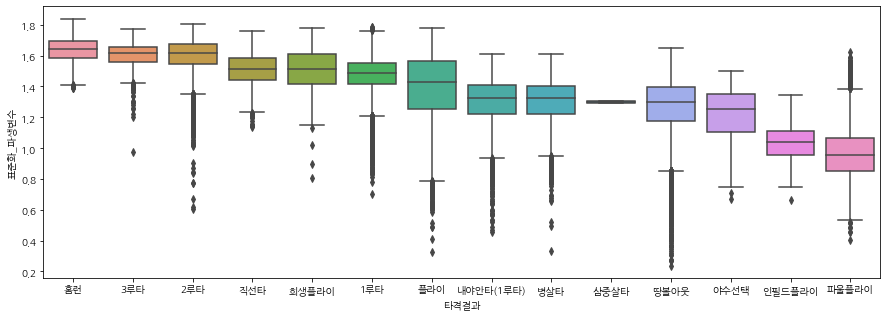

In [65]:
plt.subplots(figsize=(15, 5))
sns.boxplot(x = '타격결과',y = '표준화_파생변수', data=hts_pasaeng, order = ['홈런', '3루타', '2루타', '직선타', '희생플라이', 
                                                              '1루타', '플라이', '내야안타(1루타)', '병살타', '삼중살타',
                                                             '땅볼아웃', '야수선택', '인필드플라이', '파울플라이'])

In [30]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,0.607341,0.756966,10299.453773,1.364307
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,0.625718,0.875421,12014.414167,1.501139
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.711760,0.787879,12356.969593,1.499639
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,0.518552,0.915825,10516.502365,1.434377
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.759151,0.803591,13353.051819,1.562743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.655930,0.709315,10461.916971,1.365245
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,0.455481,0.879301,9019.537136,1.334781
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.683945,0.861343,12866.538175,1.545288
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.680350,0.967965,14191.589728,1.648315


In [31]:
########### hts 파일 최종 완료

hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,0.607341,0.756966,10299.453773,1.364307
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,0.625718,0.875421,12014.414167,1.501139
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.711760,0.787879,12356.969593,1.499639
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,0.518552,0.915825,10516.502365,1.434377
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.759151,0.803591,13353.051819,1.562743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.655930,0.709315,10461.916971,1.365245
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,0.455481,0.879301,9019.537136,1.334781
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.683945,0.861343,12866.538175,1.545288
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.680350,0.967965,14191.589728,1.648315


In [32]:
hts_pasaeng.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000
mean,69755.175636,4.934194,133.990547,17.474867,0.400261,0.552021,80.063996,0.619778,0.776508,10815.254718,1.396286
std,7390.640284,2.585314,20.778306,24.046791,0.489953,0.942156,13.906432,0.103762,0.156077,2732.040763,0.211961
min,50054.000000,1.000000,9.880000,-68.100000,0.000000,0.000000,10.877158,0.000000,0.000000,427.041683,0.236798
25%,63963.000000,3.000000,121.850000,-1.400000,0.000000,0.000000,71.277158,0.559151,0.677890,9103.509458,1.281572
50%,69209.000000,5.000000,137.770000,14.600000,0.000000,0.000000,81.922842,0.638652,0.797370,11139.226140,1.432686
75%,76313.000000,7.000000,149.520000,32.200000,1.000000,1.000000,91.577158,0.697328,0.905724,12847.875897,1.553239
max,99810.000000,12.000000,210.130000,89.800000,1.000000,4.000000,99.977158,1.000000,1.000000,17812.930174,1.840400


In [33]:
# barrel_point를 조절하면서 안타 5할, 장타율 1.5의 범위를 찾아야 함
barrel_point = 1.6189

# 위의 barrel_point의 이상의 타구들을 barrel1으로 설정
barrel1 = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > barrel_point)]

# 그리고 위의 barrel_point의 이상을 넘는 타구는 배럴여부 col에 1로 표시
hts_pasaeng['배럴여부'] = 0
hts_pasaeng['배럴여부'][(hts_pasaeng['표준화_파생변수'] > barrel_point)] = 1

In [34]:
hts_pasaeng['배럴여부'].sum()

15382

In [35]:
barrel1.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000
mean,70288.301196,4.964374,153.357568,19.811539,0.638799,1.472500,95.708591,0.716492,0.952092,14664.423619,1.668585
std,7293.645790,2.571549,7.857081,5.191882,0.480364,1.484372,3.163163,0.039236,0.035501,651.886327,0.036313
min,50054.000000,1.000000,134.250000,-4.100000,0.000000,0.000000,74.877158,0.621074,0.718294,13401.216589,1.618913
25%,64300.000000,3.000000,147.660000,16.100000,0.000000,0.000000,93.677158,0.688040,0.929293,14177.126730,1.638956
50%,70410.000000,5.000000,153.380000,20.000000,1.000000,1.000000,96.277158,0.716604,0.958474,14552.072936,1.661549
75%,76313.000000,7.000000,158.890000,23.500000,1.000000,2.000000,98.277158,0.744120,0.980920,15072.191614,1.691643
max,99810.000000,12.000000,195.250000,38.400000,1.000000,4.000000,99.977158,0.925693,1.000000,17812.930174,1.840400


- 18시즌 삼진 : 	10688
- 19시즌 삼진 : 9595
- 20시즌 삼진 : 9855
- 21시즌 삼진 : 6000(추정치)
- 합계
- 10688+9595+9855+6000

## 배럴타구 범위 설정
 - 안타여부 col은 0, 1로 이루어져 있으므로 .sum()
 - 타율은 삼진을 포함하고 볼넷, 희생플라이, 희생번트를 제외하고 계산하는 것인데 번트는 이미 삭제했고, 희생플라이 제외
 - 해당 기간의 삼진 갯수 10688+9595+9855+6000에 hts DF에서 barrel1으로 설정된 비율을 곱해서 대략적인 삼진갯수를 포함
 
 
**근데 이게 오류가 있을 수도 있어서 아이디어 부탁합니다...**

In [36]:
hitter = pd.read_csv('타자 기본.csv', encoding = 'CP949')

In [37]:
# 안타
barrel1['안타여부'].sum()/(len(barrel1['안타여부'])
                       + (10688+9595+9855+6000)*len(barrel1)/len(hts) 
                       - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

0.5001434655327748

In [38]:
# 장타
barrel1['장타여부'].sum()/(len(barrel1['장타여부']) 
                       - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

1.5069860279441119

<AxesSubplot:xlabel='타구속도', ylabel='발사각도'>

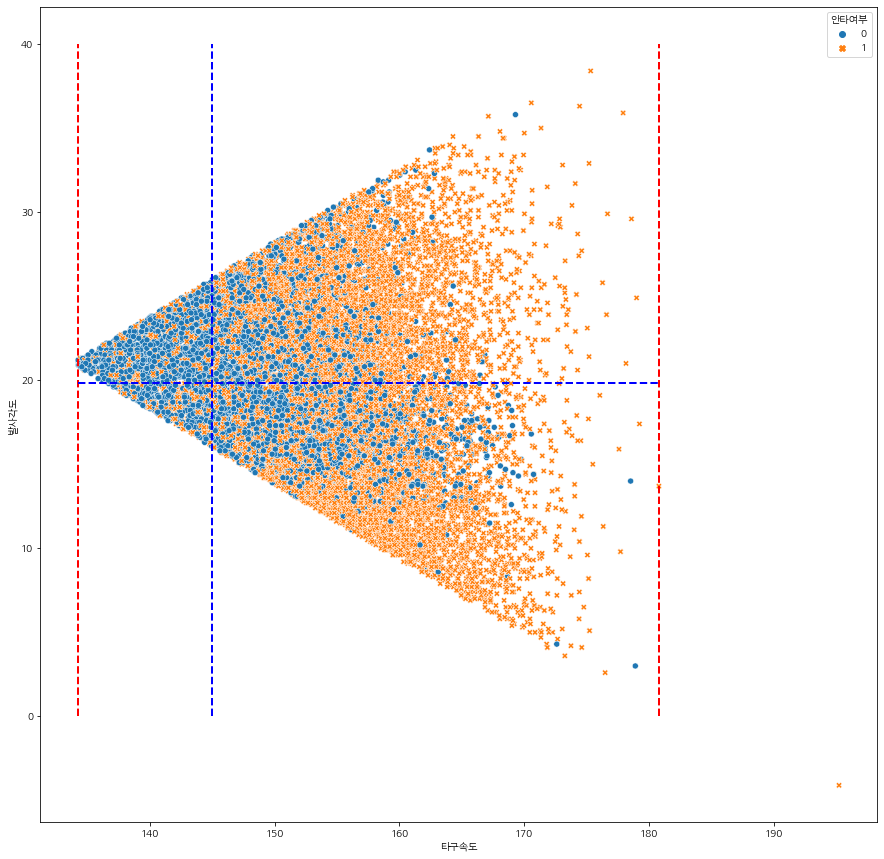

In [39]:
plt.subplots(figsize=(15, 15))
plt.plot([134.25, 134.25], [0, 40], "--r", linewidth=2) #min

plt.plot([145.0, 145.0], [0, 40], "--b", linewidth=2)

plt.plot([180.81, 180.81], [0, 40], "--r", linewidth=2) #max
plt.plot([134.25, 180.81], [19.811539461708612, 19.811539461708612], "--b", linewidth=2)
sns.scatterplot(x="타구속도", y="발사각도", hue = '안타여부', style = '안타여부', data=barrel1)

In [40]:
barrel1['타구속도'].min()

134.25

In [41]:
a = 160
b = 161
c = 162
d = 163

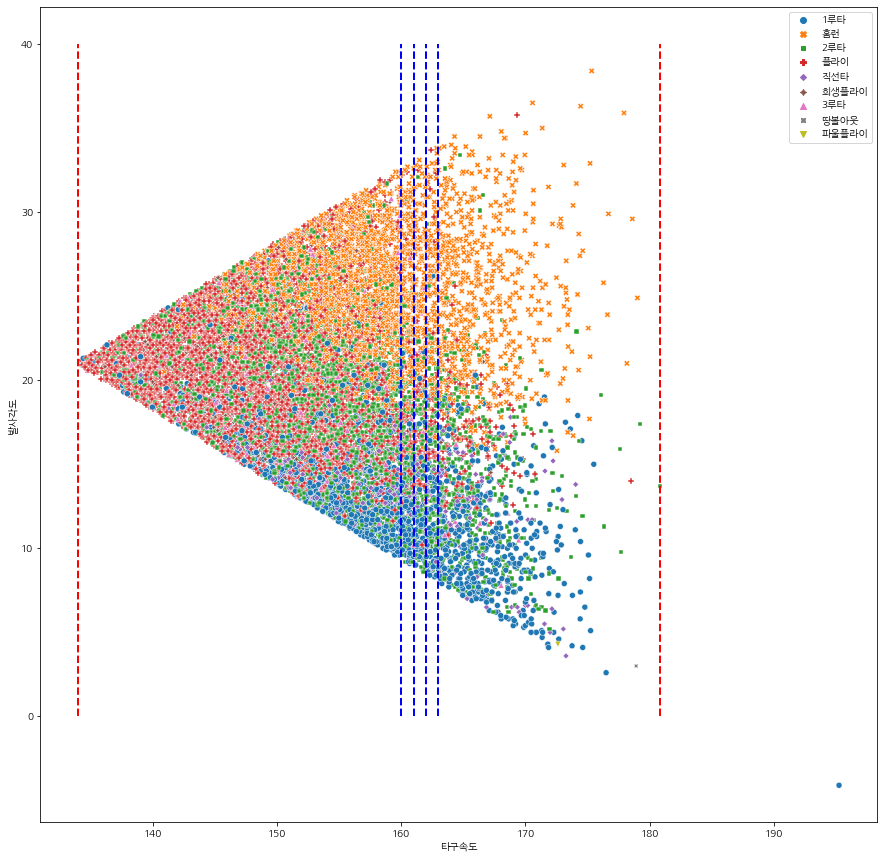

In [42]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(x="타구속도", y="발사각도", hue = '타격결과', style = '타격결과', data=barrel1)
plt.plot([134.0, 134.0], [0, 40], "--r", linewidth=2) #min

plt.plot([a, a], [0, 40], "--b", linewidth=2) # 9.312
plt.plot([b, b], [0, 40], "--b", linewidth=2)
plt.plot([c, c], [0, 40], "--b", linewidth=2)
plt.plot([d, d], [0, 40], "--b", linewidth=2)

plt.plot([180.81, 180.81], [0, 40], "--r", linewidth=2) #max
# plt.plot([134.25, 180.81], [19.811539461708612, 19.811539461708612], "--b", linewidth=2)

plt.legend()
plt.show()

In [43]:
barrel_1 = barrel1[(barrel1['타구속도']>=134.25) &(barrel1['타구속도']<a)]
barrel_2 = barrel1[(barrel1['타구속도']>=a) &(barrel1['타구속도']<b)]
barrel_3 = barrel1[(barrel1['타구속도']>=b) &(barrel1['타구속도']<c)]
barrel_4 = barrel1[(barrel1['타구속도']>=c) &(barrel1['타구속도']<d)]
barrel_5 = barrel1[(barrel1['타구속도']>=d) &(barrel1['타구속도']<180.81)]

In [44]:
print('-----------안타여부-----------')
print('1 : ', barrel_1['안타여부'].sum() / (len(barrel_1['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_1)/len(hts)
                                       - len(barrel_1.loc[(barrel_1['타격결과'] == '희생플라이')])))

print('2 : ', barrel_2['안타여부'].sum() / (len(barrel_2['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_2)/len(hts)
                                       - len(barrel_2.loc[(barrel_2['타격결과'] == '희생플라이')])))

print('3 : ', barrel_3['안타여부'].sum() / (len(barrel_3['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_3)/len(hts)
                                       - len(barrel_3.loc[(barrel_3['타격결과'] == '희생플라이')])))

print('4 : ', barrel_4['안타여부'].sum() / (len(barrel_4['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_4)/len(hts)
                                       - len(barrel_4.loc[(barrel_4['타격결과'] == '희생플라이')])))

print('5 : ', barrel_5['안타여부'].sum() / (len(barrel_5['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_5)/len(hts)
                                       - len(barrel_5.loc[(barrel_5['타격결과'] == '희생플라이')])))
# print('2 : ', barrel_2['안타여부'].mean())
# print('3 : ', barrel_3['안타여부'].mean())
# print('4 : ', barrel_4['안타여부'].mean())
# print('5 : ', barrel_5['안타여부'].mean())

# barrel1['안타여부'].sum()/(len(barrel1['안타여부'])
#                        + (10688+9595+9855+6000)*len(barrel1)/len(hts) 
#                        - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

print('-----------장타여부-----------')


print('1 : ', barrel_1['장타여부'].sum()/(len(barrel_1['장타여부']) 
                       - len(barrel_1.loc[(barrel1['타격결과'] == '희생플라이')])))

print('2 : ', barrel_2['장타여부'].sum()/(len(barrel_2['장타여부']) 
                       - len(barrel_2.loc[(barrel1['타격결과'] == '희생플라이')])))

print('3 : ', barrel_3['장타여부'].sum()/(len(barrel_3['장타여부']) 
                       - len(barrel_3.loc[(barrel1['타격결과'] == '희생플라이')])))

print('4 : ', barrel_4['장타여부'].sum()/(len(barrel_4['장타여부']) 
                       - len(barrel_4.loc[(barrel1['타격결과'] == '희생플라이')])))

print('5 : ', barrel_5['장타여부'].sum()/(len(barrel_5['장타여부']) 
                       - len(barrel_5.loc[(barrel1['타격결과'] == '희생플라이')])))
# print('2 : ', barrel_2['장타여부'].mean())
# print('3 : ', barrel_3['장타여부'].mean())
# print('4 : ', barrel_4['장타여부'].mean())
# print('5 : ', barrel_5['장타여부'].mean())

print('-------------갯수-------------')
print('1 : ', len(barrel_1))
print('2 : ', len(barrel_2))
print('3 : ', len(barrel_3))
print('4 : ', len(barrel_4))
print('5 : ', len(barrel_5))
print('total :', len(barrel_1) + len(barrel_2) + len(barrel_3) + len(barrel_4) + len(barrel_5))

-----------안타여부-----------
1 :  0.4480085464426307
2 :  0.670449667598077
3 :  0.6671523828255937
4 :  0.6837658436156491
5 :  0.7140351080925336
-----------장타여부-----------
1 :  1.330071699704766
2 :  2.0585009140767823
3 :  2.0426439232409384
4 :  2.18
5 :  2.2327831531018782
-------------갯수-------------
1 :  12189
2 :  548
3 :  475
4 :  402
5 :  1766
total : 15380


In [45]:
len(barrel1)

15382

In [46]:
barrel1 = barrel1.reset_index(drop = True)

- barrel1에 있는 타격결과들을 살펴본 결과 파울플라이가 있어서 봄

In [47]:
barrel1['타격결과'].value_counts()

플라이      5197
2루타      4113
홈런       2869
1루타      1979
직선타       542
희생플라이     352
3루타       323
땅볼아웃        6
파울플라이       1
Name: 타격결과, dtype: int64

In [48]:
barrel1.loc[(barrel1['타격결과'] == '파울플라이')]

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
8474,20190908OBLG0,69165,1,172.62,4.3,파울플라이,0,0,83.277158,0.812684,0.81257,14375.302949,1.625254


In [49]:
player = pd.read_csv('선수.csv', encoding = 'CP949')

In [50]:
player.loc[(player['선수코드'] == 69165)]

,연도,선수코드,선수명,팀코드,포지션,나이,연봉
1072,2019,69165,페게로,LG,내,32,150000달러


https://sports.news.naver.com/kbaseball/vod/index?id=581483&category=kbo&gameId=20190908OBLG02019&date=20190908&listType=game

- 여기 19분 43초부터 보면 매우 잘 맞은 직선타인데 파울 공간에서 잡아서 파울플라이로 표시함;;
 - 잘못 필터링 된 것이 아님을 확인

In [51]:
barrel1.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000,15382.000000
mean,70288.301196,4.964374,153.357568,19.811539,0.638799,1.472500,95.708591,0.716492,0.952092,14664.423619,1.668585
std,7293.645790,2.571549,7.857081,5.191882,0.480364,1.484372,3.163163,0.039236,0.035501,651.886327,0.036313
min,50054.000000,1.000000,134.250000,-4.100000,0.000000,0.000000,74.877158,0.621074,0.718294,13401.216589,1.618913
25%,64300.000000,3.000000,147.660000,16.100000,0.000000,0.000000,93.677158,0.688040,0.929293,14177.126730,1.638956
50%,70410.000000,5.000000,153.380000,20.000000,1.000000,1.000000,96.277158,0.716604,0.958474,14552.072936,1.661549
75%,76313.000000,7.000000,158.890000,23.500000,1.000000,2.000000,98.277158,0.744120,0.980920,15072.191614,1.691643
max,99810.000000,12.000000,195.250000,38.400000,1.000000,4.000000,99.977158,0.925693,1.000000,17812.930174,1.840400


In [52]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,0.607341,0.756966,10299.453773,1.364307,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,0.625718,0.875421,12014.414167,1.501139,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.711760,0.787879,12356.969593,1.499639,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,0.518552,0.915825,10516.502365,1.434377,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.759151,0.803591,13353.051819,1.562743,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.655930,0.709315,10461.916971,1.365245,0
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,0.455481,0.879301,9019.537136,1.334781,0
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.683945,0.861343,12866.538175,1.545288,0
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.680350,0.967965,14191.589728,1.648315,1


In [53]:
barrel1

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,71752,3,155.49,21.0,1루타,1,1,99.977158,0.727141,1.000000,15545.448239,1.727141
1,20180324HHWO0,76746,3,165.04,20.3,홈런,1,4,99.277158,0.774831,0.992144,16384.702094,1.766975
2,20180324HHWO0,67341,4,151.98,18.4,2루타,1,2,97.377158,0.709613,0.970819,14799.380416,1.680432
3,20180324HHWO0,67341,5,141.49,23.0,플라이,0,0,98.022842,0.657228,0.978066,13869.251968,1.635295
4,20180324HHWO0,61353,6,141.75,20.1,플라이,0,0,99.077158,0.658527,0.989899,14044.187093,1.648426
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15377,20210711KTHT0,64166,2,149.05,17.6,플라이,0,0,96.577158,0.694981,0.961841,14394.825344,1.656822
15378,20210711KTHT0,78603,6,142.02,22.4,2루타,1,2,98.622842,0.659875,0.984800,14006.416074,1.644675
15379,20210711LTSS0,66838,2,149.83,18.6,희생플라이,0,0,97.577158,0.698876,0.973064,14619.985527,1.671940
15380,20210711LTSS0,71564,4,152.75,15.2,1루타,1,1,94.177158,0.713458,0.934905,14385.560827,1.648363


In [54]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,0.607341,0.756966,10299.453773,1.364307,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,0.625718,0.875421,12014.414167,1.501139,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.711760,0.787879,12356.969593,1.499639,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,0.518552,0.915825,10516.502365,1.434377,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.759151,0.803591,13353.051819,1.562743,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.655930,0.709315,10461.916971,1.365245,0
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,0.455481,0.879301,9019.537136,1.334781,0
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.683945,0.861343,12866.538175,1.545288,0
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.680350,0.967965,14191.589728,1.648315,1


In [55]:
Rojas = hts_pasaeng[hts_pasaeng['선수코드'] == 67025]
Rojas

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
72,20180324KTHT0,67025,6,147.62,27.7,홈런,1,4,93.322842,0.687840,0.925316,13776.317992,1.613157,0
81,20180324KTHT0,67025,7,165.54,24.1,홈런,1,4,96.922842,0.777328,0.965720,16044.607327,1.743049,1
267,20180325KTHT0,67025,1,103.12,50.4,플라이,0,0,70.622842,0.465618,0.670546,7282.627506,1.136164,0
288,20180325KTHT0,67025,4,128.61,23.2,플라이,0,0,97.822842,0.592909,0.975821,12580.995758,1.568730,0
304,20180325KTHT0,67025,7,150.35,0.6,1루타,1,1,79.577158,0.701473,0.771044,11964.425649,1.472517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102018,20201029KTHH0,67025,1,120.89,17.4,1루타,1,1,96.377158,0.554357,0.959596,11651.034585,1.513953,0
102048,20201029KTHH0,67025,6,153.36,13.8,1루타,1,1,92.777158,0.716504,0.919192,14228.304893,1.635696,1
102233,20201030KTHH0,67025,1,145.88,-1.6,1루타,1,1,77.377158,0.679151,0.746352,11287.779754,1.425503,0
102239,20201030KTHH0,67025,2,140.64,49.3,플라이,0,0,71.722842,0.652984,0.682892,10087.100552,1.335876,0


In [56]:
Rojas['배럴여부'].sum()/1851

0.1323608860075635

In [57]:
hitter = pd.read_csv('타자 기본.csv', encoding = 'CP949')

In [58]:
def barrel_ws(df_hts, df_player,df_hitter,name,point):
    code = df_player[df_player['선수명'] == name]['선수코드'].unique()[0] #이름 입력 받아서 선수코드 int로 가져옴
    
    df_name = hts_pasaeng[hts_pasaeng['선수코드'] == code]
#     df_name = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > point)]
#     df_name = df_name[(df_name['발사각도'] > 15) & (df_name['발사각도'] < 35)]
    
    #타율(BA) 계산하기 위해 필요
    ba = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] + df_name[df_name['타격결과'] == '3루타'].shape[0] +df_name[df_name['타격결과'] == '홈런'].shape[0]
    #장타율(SLG) 계산하기 위해 필요
    slg = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] *2 + df_name[df_name['타격결과'] == '3루타'].shape[0] * 3 + df_name[df_name['타격결과'] == '홈런'].shape[0]*4
    
    print('----------', name,'----------')
#     print('타율 = ',ba , '/',df_name.shape[0], ' = ', ba / df_name.shape[0])
#     print('장타율 = ',slg , '/',df_name.shape[0], ' = ', slg / df_name.shape[0])
    print('배럴타구 = ',df_name['배럴여부'].sum() )
    print('배럴타구 / 타석 = ',df_name['배럴여부'].sum(), '/', df_hitter[df_hitter['선수코드'] == code]['타석'].sum(), 
                                                  '=',df_name['배럴여부'].sum() / df_hitter[df_hitter['선수코드'] == code]['타석'].sum())
    print()
    

- 효림이 함수를 수정해서 top20 선수들 barrel을 본 결과 대부분 10% 초반을 기록했으며, 효림이의 결과와 비슷한 양상을 보임

In [59]:
name_list = ['양의지', '강백호', '최정', '이정후', '홍창기', '피렐라', '강민호', '박동원', '나성범', '박건우',
            '김재환', '페르난데스', '김현수', '양석환', '알테어', '정훈', '추신수', '구자욱', '안치홍', '한유섬']

for name in name_list:
    barrel_ws(hts, player, hitter, name, barrel_point)

---------- 양의지 ----------
배럴타구 =  242
배럴타구 / 타석 =  242 / 1792 = 0.13504464285714285

---------- 강백호 ----------
배럴타구 =  218
배럴타구 / 타석 =  218 / 1993 = 0.10938283993978926

---------- 최정 ----------
배럴타구 =  206
배럴타구 / 타석 =  206 / 1953 = 0.10547875064004096

---------- 이정후 ----------
배럴타구 =  192
배럴타구 / 타석 =  192 / 2123 = 0.09043805934997645

---------- 홍창기 ----------
배럴타구 =  92
배럴타구 / 타석 =  92 / 899 = 0.10233592880978866

---------- 피렐라 ----------
배럴타구 =  37
배럴타구 / 타석 =  37 / 361 = 0.10249307479224377

---------- 강민호 ----------
배럴타구 =  141
배럴타구 / 타석 =  141 / 1533 = 0.09197651663405088

---------- 박동원 ----------
배럴타구 =  115
배럴타구 / 타석 =  115 / 1122 = 0.10249554367201426

---------- 나성범 ----------
배럴타구 =  191
배럴타구 / 타석 =  191 / 1648 = 0.11589805825242719

---------- 박건우 ----------
배럴타구 =  244
배럴타구 / 타석 =  244 / 1863 = 0.13097155126140633

---------- 김재환 ----------
배럴타구 =  280
배럴타구 / 타석 =  280 / 2079 = 0.13468013468013468

---------- 페르난데스 ----------
배럴타구 =  156
배럴타구 / 타석 =  156 / 1632 = 0.0955

In [60]:
hts3

NameError: name 'hts3' is not defined